# Import des packages nécessaires

In [5]:
import warnings
import itertools
import numpy as np
import matplotlib.pyplot as plt
warnings.filterwarnings("ignore")
plt.style.use('fivethirtyeight')
import pandas as pd
import geopandas as gpd
import statsmodels.api as sm
import matplotlib
import datetime

# Récupération des fonctions des autres notebooks et des dataset

In [1]:
#Entree par l'utilisateur de info sur son domicile 
dep = (input("Code departement (ex : 75)"))
num = int(input("Numero"))
nom_voie = input("Nom de la voie")
ville = input('Ville')
code_postal = input("Code postal")

Departement44
Numero4
Nom de la voierue fouré
VilleNantes
Code postal44000


In [8]:
import levenstein

In [18]:
def addresse_to_GPS(dep, num, nom_voie, ville, code_postal):
    adresses_dep = pd.read_csv("https://adresse.data.gouv.fr/data/ban/adresses/latest/csv/adresses-"+dep+".csv.gz", compression='gzip', sep=";", error_bad_lines=False) #recuperation des adresses postales correspondant au département de l'utilisateur
    #Correction de l'ortographe de la ville et de la rue (si necessaire) pour que cela fit au mieux avec le dataframe
    #On utilise pour cela la minimisation de la distance de Levenstein
    
    ville=levenstein.get_ville_correct(ville,adresses_dep) 
    nom_voie=levenstein.get_rue_corect(nom_voie,adresses_dep)

    foyer_infos = adresses_dep[(adresses_dep["numero"] == num) & (adresses_dep["nom_commune"] == ville) & (adresses_dep["nom_voie"] == nom_voie)] 
    foyer = foyer_infos.to_numpy()
    foyer = foyer.tolist()

    
    longitude = foyer[0][12]
    latitude = foyer[0][13]

    return(longitude, latitude, ville, nom_voie)

In [19]:
long, lat, ville, nom_voie = addresse_to_GPS(dep, num, nom_voie, ville, code_postal) #On corrige au passage l'addresse
long, lat

(-1.546307, 47.214242, 'Rue Fouré')

# Nucléaire 

### Récupération des tables de données

In [7]:
centrales = pd.read_csv("DataSets/centrales_nucleaires.csv",sep=',',encoding_errors='ignore')

In [8]:
import Nucleaire

In [9]:
rNu = Nucleaire.nucleaire(long, lat, centrales)
rNu

La centrale nucleaire la plus proche se situe à :
9979.717702772043 Fessenheim
Le risque nucléaire à cette adresse est de :


5

# Inondations

### Récupération des tables de données

In [ ]:
df_risque_inond=gpd.read_file("DataSets/tri_2020_sig_di/n_carte_inond_s.shp") 

# Glissement de terrains

### Récupération des tables de données

In [10]:
df_mvtTerrains13 = pd.read_csv("DataSets/mouvement_terrain_13.csv", sep = ";")
df_mvtTerrains31 = pd.read_csv("DataSets/mouvement_terrain_31.csv", sep = ";")
df_mvtTerrains44 = pd.read_csv("DataSets/mouvement_terrain_44.csv", sep = ";")

### Import des fonctions

In [11]:
import glissement_terrain

In [12]:
long, lat = addresse_to_GPS(dep, num, nom_voie, ville, code_postal)

In [14]:
dico = glissement_terrain.event_less_10km(lat, long, df_mvtTerrains44)
riGdT,quali_data= glissement_terrain.calcul_risque(dico)

# Secheresse

### Récupération des tables de données

In [15]:
import secheresse

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


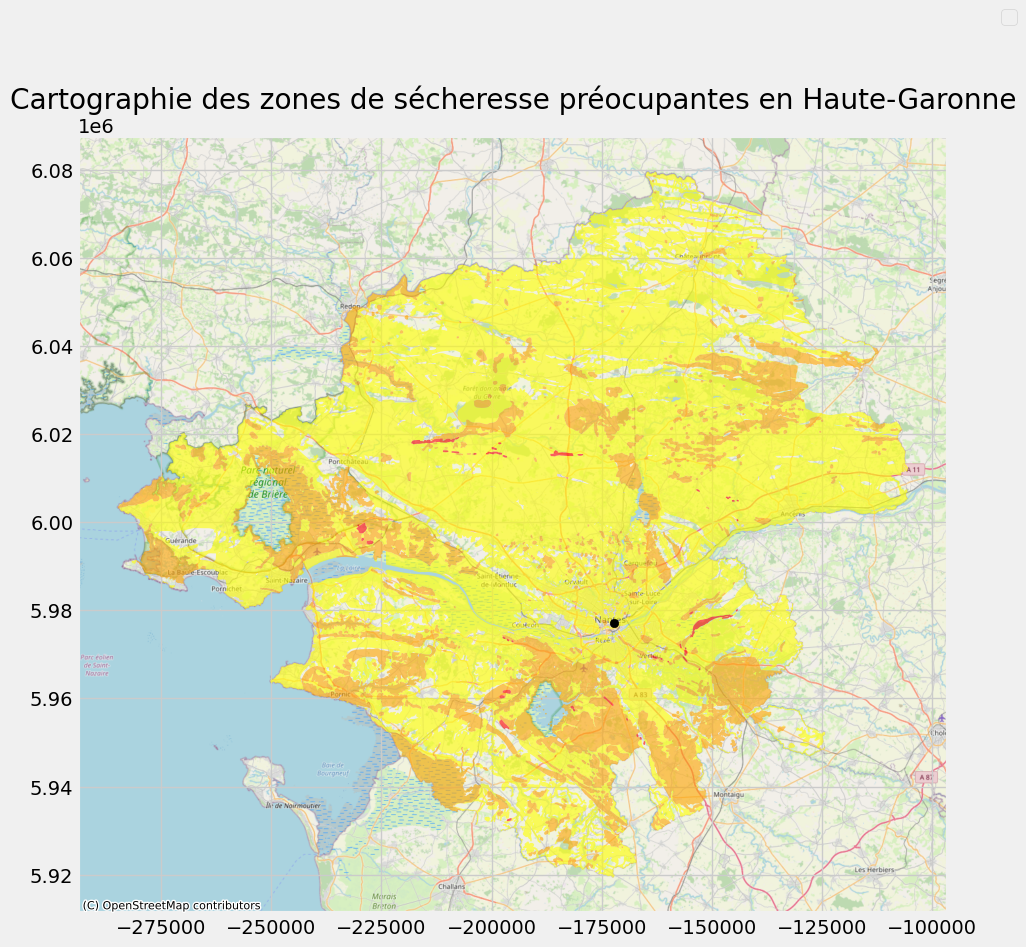

Le score de sécheresse (de 1 à 5) de l'habitation est de :1.5509838998211092


In [16]:
rSe = secheresse.secheresse(dep, num, nom_voie, ville, code_postal) * 5

# Pollution

### Récupération des tables de données

In [17]:
df_PM10 = pd.read_csv("DataSets/"+dep+"/PM10.csv", sep = ";")
df_SO2 = pd.read_csv("DataSets/"+dep+"/SO2.csv", sep = ";")
df_CO = pd.read_csv("DataSets/"+dep+"/CO.csv", sep = ";")

### code

In [18]:
import Pollution

In [19]:
rPol = Pollution.risque_polution(lat, long, df_CO, df_SO2, df_PM10)
rPol

4

# Temperature

### Récupération des tables de données

In [32]:
df_temp13 = pd.read_csv("DataSets/temperature_"+dep+".csv", sep = ";")

### Code

In [31]:
import temperature

In [22]:
#On modifie les tables pour les rendre exploitables
df_temp13=temperature.preprocessing(df_temp13)

In [23]:
#On vérifie que l'on a bien au moins une mesure par semaine dans nos tables (pour pouvoir fixer la saisonalité à 52)
temperature.test_saisonalité(df_temp13)

True
True
True
True
True
True
True
True
True
True
True
True


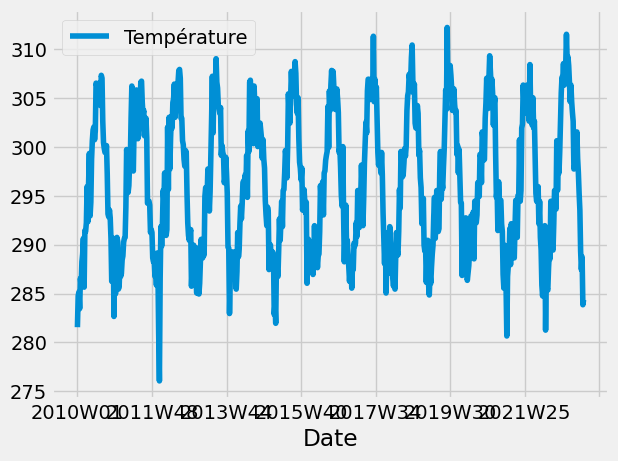

<Figure size 400x100 with 0 Axes>

In [24]:
#Temperature maximale journalière au cours du temps 
#On remarque une belle saisonalité annuelle, ce qui est particulièrement adapté dans le cadre d'une utilisation du model SARIMA
temperature.plot_temperature(df_temp13)

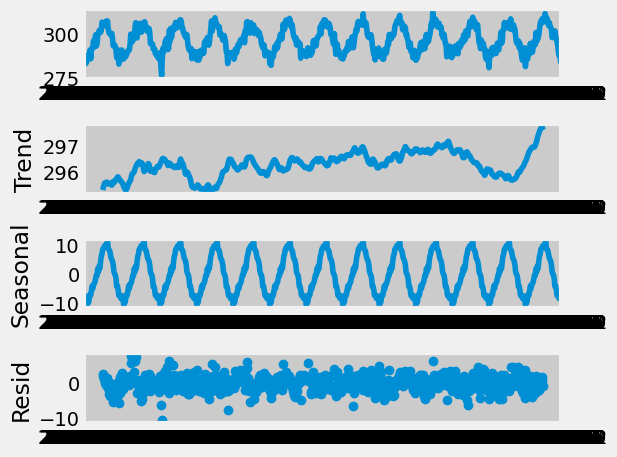

In [25]:
#décomposition de la série temporelle en composante saisonnelle, tendance et en bruit
temperature.get_decomposition(df_temp13)

 This problem is unconstrained.


RUNNING THE L-BFGS-B CODE

           * * *

Machine precision = 2.220D-16
 N =            5     M =           10

At X0         0 variables are exactly at the bounds

At iterate    0    f=  1.91536D+00    |proj g|=  1.47973D-01

At iterate    5    f=  1.84508D+00    |proj g|=  9.30071D-02

At iterate   10    f=  1.84145D+00    |proj g|=  1.76032D-04

           * * *

Tit   = total number of iterations
Tnf   = total number of function evaluations
Tnint = total number of segments explored during Cauchy searches
Skip  = number of BFGS updates skipped
Nact  = number of active bounds at final generalized Cauchy point
Projg = norm of the final projected gradient
F     = final function value

           * * *

   N    Tit     Tnf  Tnint  Skip  Nact     Projg        F
    5     12     17      1     0     0   3.804D-05   1.841D+00
  F =   1.8414518419765613     

CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH             


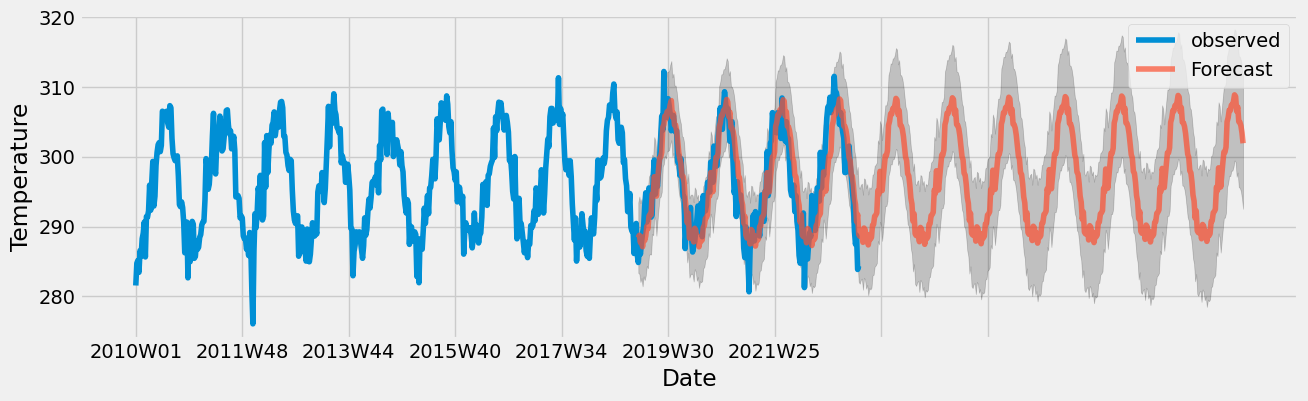

In [26]:
#retourne les prédiction de temprérature pour un horizon donné, les paramètres du model sont pré rentrés. 
#model entrainé entre 2010 et 2019 et testé sur 2019, 2020, 2021, mi 2022
pred, pred_ci=temperature.get_prediction_graph(2030,df_temp13)

In [27]:
Te = temperature.temperature_max(pred,pred_ci)

la temperature maximale annuelle prédite est:
35.89544361969155
l'intervalle de confiance à 95 est:
45.29969377606528
26.491193463317813


In [29]:
rTe = (Te / 50) * 20
rTe

14.358177447876619

# Code principal

In [ ]:
vec_risque = [rNu, rPol, rSe, rTe, riGdT]

In [ ]:
note_final = sum(vec_risque)
note_final

In [ ]:
sample_vect = [12/20, 13/20, 0.4, 6/20, 8/20, 10/20]

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.tri as tri

proportions = sample_vect
labels = ['Nucléaire', 'Inondation', 'Glissements de terrains', 'Sécheresse', 'Pollution', 'Température']
N = len(proportions)
proportions = np.append(proportions, 1)
theta = np.linspace(0, 2 * np.pi, N, endpoint=False)
x = np.append(np.sin(theta), 0)
y = np.append(np.cos(theta), 0)
triangles = [[N, i, (i + 1) % N] for i in range(N)]
triang_backgr = tri.Triangulation(x, y, triangles)
triang_foregr = tri.Triangulation(x * proportions, y * proportions, triangles)
cmap = plt.cm.rainbow_r  # or plt.cm.hsv ?
colors = np.linspace(0, 1, N + 1)
plt.tripcolor(triang_backgr, colors, cmap=cmap, shading='gouraud', alpha=0.4)
plt.tripcolor(triang_foregr, colors, cmap=cmap, shading='gouraud', alpha=0.8)
plt.triplot(triang_backgr, color='white', lw=2)
for label, color, xi, yi in zip(labels, colors, x, y):
    plt.text(xi * 1.05, yi * 1.05, label,  # color=cmap(color),
             ha='left' if xi > 0.1 else 'right' if xi < -0.1 else 'center',
             va='bottom' if yi > 0.1 else 'top' if yi < -0.1 else 'center')
plt.axis('off')
plt.gca().set_aspect('equal')
plt.title("Répartition des risques")
plt.show()
